# Perturbed Instrument
Here we show a minimal example of how to deal with perturbed instruments, i.e. instrumental instability noise. The most important distiction to the case of an ideal instrument (as in the first example) is the use of the `CalibrationStarZCAWhiteningModule` instead of the `NoiseVarianceNormalizationModule` to properly account for the correlations in the data introduced by the instability noise.  

**Import Necessary Modules**

We start by importing the necessary modules.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from phringe.core.entities.scene import Scene
from phringe.core.entities.sources.exozodi import Exozodi
from phringe.core.entities.sources.local_zodi import LocalZodi
from phringe.core.entities.sources.planet import Planet
from phringe.core.entities.sources.star import Star

from lifesimmc.core.modules.generating.data_generation_module import DataGenerationModule
from lifesimmc.core.modules.generating.template_generation_module import TemplateGenerationModule
from lifesimmc.core.modules.loading.setup_module import SetupModule
from lifesimmc.core.modules.processing.calibration_star_zca_whitening_module import CalibrationStarZCAWhiteningModule
from lifesimmc.core.modules.processing.correlation_map_module import CorrelationMapModule
from lifesimmc.core.modules.processing.ml_parameter_estimation_module import MLParameterEstimationModule
from lifesimmc.core.pipeline import Pipeline
from lifesimmc.lib.colormaps import cmap_blue
from lifesimmc.lib.instrument import LIFEReferenceDesign, InstrumentalNoise
from lifesimmc.lib.observation import LIFEReferenceObservation

### Simulation Setup


**Define Instrument and Observation**

We first define the `Instrument` and `Observation` objects.


In [2]:
# Here we define an instrument with an 'pessimistic' amount of perturbations (as defined in Huber et al. 2025); OPTIMISTIC is also an option
inst = LIFEReferenceDesign(instrumental_noise=InstrumentalNoise.PESSIMISTIC)

# For this example, manually update the spectral resolving power and aperture diameter
inst.spectral_resolving_power = 30
inst.aperture_diameter = 2

# User the predefined observation for the LIFE baseline design
obs = LIFEReferenceObservation(
    total_integration_time='10 d',
    detector_integration_time='0.05 d',  # should be chosen small enough to sufficiently sample the planet signal
    optimized_star_separation='habitable-zone'
)

**Define Astrophysical Scene**

Next we define the astrophysical `Scene` and add `Star`, `LocalZodi`, `Exozodi` and `Planet` objects to it.

In [3]:
scene = Scene()

sun_twin = Star(
    name='Sun Twin',
    distance='10 pc',
    mass='1 Msun',
    radius='1 Rsun',
    temperature='5700 K',
    right_ascension='10 hourangle',
    declination='45 deg',
)

local_zodi = LocalZodi()

exozodi = Exozodi(level=3)

earth_twin = Planet(
    name='Earth Twin',
    has_orbital_motion=False,
    mass='1 Mearth',
    radius='1 Rearth',
    temperature='254 K',
    semi_major_axis='1 au',
    eccentricity='0',
    inclination='0 deg',
    raan='90 deg',
    argument_of_periapsis='0 deg',
    true_anomaly='45 deg',
    input_spectrum=None,
)

scene.add_source(sun_twin)
scene.add_source(local_zodi)
scene.add_source(exozodi)
scene.add_source(earth_twin)

**Set Up Pipeline For Data Generation**

Then we set up the pipeline by first creating a `Pipeline` object and then adding the `SetupModule`, to which we pass objects we have created above.


In [4]:
# Create the pipeline
pipeline = Pipeline(gpu_index=2, seed=42, grid_size=40)

# Setup the simulation
module = SetupModule(
    n_setup_out='setup',
    n_planet_params_out='params_init',
    instrument=inst,
    observation=obs,
    scene=scene
)
pipeline.add_module(module)

# Generate the raw data
module = DataGenerationModule(n_setup_in='setup', n_data_out='data')
pipeline.add_module(module)

# Generate the templates
module = TemplateGenerationModule(n_setup_in='setup', n_template_out='temp', fov=1e-6)
pipeline.add_module(module)

### Pre-Processing

**Whiten Data and Templates**

The perturbations in our instrument lead spectral (and temporal) correlations in our data that not only strongly influence the quality of the signal extraction but also result in highly non-Gaussian-distributed data. To account for this, we *whiten* the data using a *ZCA whitening transformation* (e.g. Ceau et al. 2019; Huber et al. 2025). The whitening transformatoin requires an estimation of the true noise covariance of our data, which we approximate here with the noise covariance from a calibration star observation (see discussion in Huber et al. 2025).    


In [5]:
module = CalibrationStarZCAWhiteningModule(
    n_setup_in='setup',
    n_data_in='data',
    n_template_in='temp',  # Optional
    n_data_out='data_white',
    n_template_out='temp_white',  # Optional
    n_transformation_out='zca',
)
pipeline.add_module(module)

**Plot Correlation Map**

To get a first glimpse at our data we can correlate them with our grid of planetary templates: 

Loading configuration...
Done
Generating synthetic data...


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Done
Generating templates...
Done
Applying ZCA whitening...


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]
/home/huberph/lifesimmc/lifesimmc/core/modules/processing/calibration_star_zca_whitening_module.py:178: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:305.)
  i_cov_sqrt[i] = torch.tensor(sqrtm(pinv(cov[i].cpu().numpy())), device=self.device, dtype=torch.float32)
100%|██████████| 1600/1600 [00:00<00:00, 16325.57it/s]


Done
Calculating correlation map...
Done


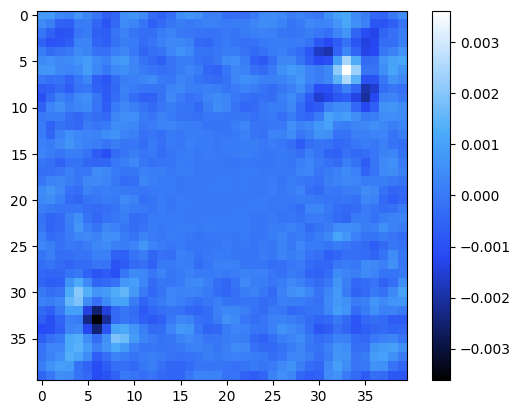

In [11]:
# Generate the correlation map
module = CorrelationMapModule(n_data_in='data_white', n_template_in='temp_white', n_image_out='imag_corr')
pipeline.add_module(module)

# Run pipeline with all modules we have added so far
pipeline.run()

# Get the correlation map from the image resource
imag_corr = pipeline.get_resource('imag_corr').get_image(as_numpy=True)

# Plot the image
plt.imshow(imag_corr, cmap=cmap_blue)
plt.colorbar()
plt.show()

### Signal Extraction

**Extract the Planetary Spectrum**

We now extract the planetary spectrum and coordinates from our data using a (numerical) maximum likelihood estimation. This will take a few seconds to run.

In [12]:
module = MLParameterEstimationModule(
    n_setup_in='setup',
    n_data_in='data_white',
    n_template_in='temp_white',
    n_transformation_in='zca',
    n_planet_params_in='params_init',
    n_planet_params_out='params_ml',
)
pipeline.add_module(module)
pipeline.run()

Performing numerical MLE...
Done


Finally, we plot the extracted flux and corresponding uncertainties. Note that we now have significantly larger uncertainties on our spectrum as compared to the ideal case from the frist example.

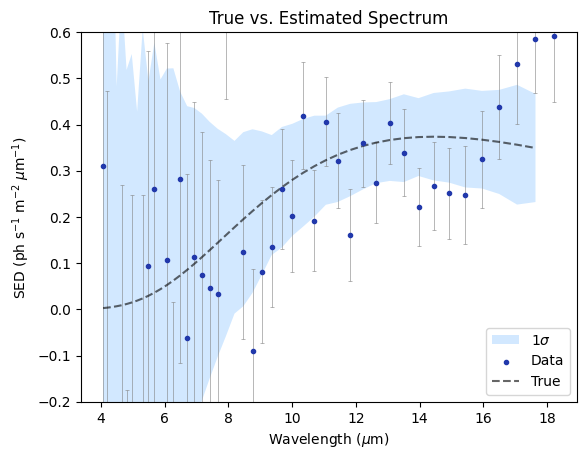

In [13]:
# Get the initial (input) parameters so we can plot the input spectrum (spectral energy distribution; SED) as a reference
params_init = pipeline.get_resource('params_init')
sed_init = params_init.params[0].sed.cpu().numpy()[:-1]  # Convert to numpy array from a torch Tensor
sed_init /= 1e6  # Convert to ph s-1 m-2 um-1
wavelengths = params_init.params[0].sed_wavelength_bin_centers.cpu().numpy()  # Convert to Torch tensor
wavelengths *= 1e6  # Convert from m to um

# Get the estimated parameters
params_ml = pipeline.get_resource('params_ml')
sed_estimated = params_ml.params[0].sed.cpu().numpy()
sed_estimated /= 1e6  # Convert to ph s-1 m-2 um-1
sed_err_low = params_ml.params[0].sed_err_low / 1e6
sed_err_high = params_ml.params[0].sed_err_high / 1e6

# Plot everything
yerr = np.stack([sed_err_low, sed_err_high])
plt.errorbar(
    wavelengths,
    sed_estimated,
    yerr=yerr,
    fmt='none',
    ecolor='gray',
    alpha=0.8,
    zorder=1,
    capsize=1.5,
    capthick=0.5,
    linewidth=0.5
)
plt.fill_between(
    wavelengths[:-1],
    np.array(sed_init) - np.array(sed_err_low)[:-1],
    np.array(sed_init) + np.array(sed_err_high)[:-1],
    color='dodgerblue',
    edgecolor=None,
    lw=0,
    alpha=0.2,
    label='1$\sigma$',
    zorder=0
)
plt.scatter(wavelengths, sed_estimated, label='Data', color="xkcd:sapphire", zorder=2, marker='.')
plt.plot(wavelengths[:-1], sed_init, label='True', linestyle='dashed', color='black', alpha=0.6, zorder=1)
plt.title('True vs. Estimated Spectrum')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('SED (ph s$^{-1}$ m$^{-2}$ $\mu$m$^{-1}$)')
plt.ylim(-0.2, 0.6)
plt.legend()
plt.show()

We can now also have a look at the full covariance of the extracted spectral values:

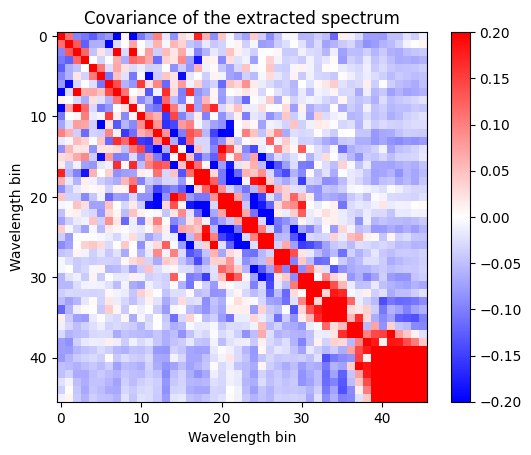

In [35]:
# Get the covariance matrix of the estimated parameters
cov = sed_estimated = params_ml.params[0].covariance

# Convert to correlation matrix
corr = np.corrcoef(cov)[:-2, :-2]  # Also remove two position coordinates

# Plot the correlation matrix in a symmetrical log plot
plt.imshow(corr, cmap='bwr', vmin=-0.2, vmax=0.2)
plt.colorbar()
plt.title('Covariance of the extracted spectrum')
plt.xlabel('Wavelength bin')
plt.ylabel('Wavelength bin')
plt.show()